# 1- Prismatic sim set-up (Graphene)

This notebook determines the input parameters for the simulated datasets.
Based on the object, we look at the diffraction overlap at the various convergence semi-angle values.
We then look into deciding on the probes and step sizes in order to reach a wide range of overlap values.

[sim starting parameters](#params)</br>
[Submitting the sim matrix to cluster](#submit)


In [1]:
# %matplotlib qt
%matplotlib inline

In [2]:
import numpy as np
import hyperspy.api as hs
import os
import h5py
import sys

In [3]:
sys.path.append('/dls/science/groups/e02/Mohsen/code/Git_Repos/Merlin-Medipix/')
import epsic_tools.api as epsic

For graphene at 80 kV below are the convergence semi-angle values and the overlap between the bf disc and the first reflection of graphene at 0.01960 rad:

| Convergence semi_angle (rad)        | Overlap in reciprocal space (%)           |
| :-------------: |:-------------:| 
| **0.008**      | **-22.5** | 
| 0.010      | 1.99      | 
| 0.012      | 18.33      | 
| **0.015** | **34.70**      | 
| 0.020      | 51.00      | 
| **0.025**  | **60.80**     |   
| **0.032** | **69.37**       |   
| **0.042** | **76.67**       | 

The bold cases are corresponding to the CL aperture sizes on G-ARM in the standard STEM alignment. The other cases are included to fill in the span of large differences in convergence angles.


In [4]:
# function to get the obove values
epsic.sim_utils.get_overlap(0.020, 0.01960)

51.0

<a id='params'></a>
# sim starting parameters:
For instructions on prismatic refer to:
https://prism-em.com/tutorial-SuperSTEM/

Accelerating voltage: 80 kV
 


**Determining sampling conditions**

Aiming for 512*512 detector pixel array, knowing our object is 3 * 29.03 A in size, we can calculate the simulation PixelSize: 

In [5]:
cell_dim = 29.03e-10 #in m
tiling_factor = 3
detector_pix_array = 512
pixel_size = cell_dim*tiling_factor / (2*detector_pix_array)
print('sim pixel size (m): ', pixel_size)

sim pixel size (m):  8.5048828125e-12


In [6]:
e_0 = 80000
l = epsic.ptycho_utils.e_lambda(e_0)
alpha_max = l / (4 * pixel_size)
print('This gives us maximum scattering angle of ',np.round(alpha_max,5) * 1e3, 'mrad')

This gives us maximum scattering angle of  122.74 mrad


We can also now calculate the pixel size in reciprocal plane:

In [7]:
print('mrad per pixel: ', alpha_max * 1e3 / detector_pix_array )
print('pixel per mrad: ', (alpha_max * 1e3 / detector_pix_array)**-1)

mrad per pixel:  0.2397356801747285
pixel per mrad:  4.17126061198384


we can also calculate the camera length:

In [8]:
detector_pixel_size = 55e-6 
CL = (detector_pix_array / 2) * detector_pixel_size / alpha_max
print(CL)

0.11470966682955559


Based on the above convergence semi-angle values, in each case we define the follwoing probe:

with maximum defocus - defined as the probe with diameter equal to half the reconstrction array, 


In [9]:
probe_diameter = pixel_size * detector_pix_array / 2
print(probe_diameter)

2.17725e-09


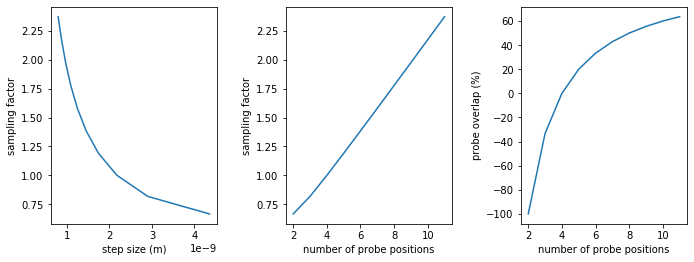

In [10]:
number_probe_pos = np.arange(2, 100)
step_size = cell_dim * tiling_factor / number_probe_pos
s_factor = epsic.ptycho_utils.get_sampling_factor(pixel_size * detector_pix_array, probe_diameter, number_probe_pos, step_size)
probe_overlap = epsic.sim_utils.get_overlap(probe_diameter/2, step_size)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(step_size[:10], s_factor[:10])
plt.xlabel('step size (m)')
plt.ylabel('sampling factor')
plt.subplot(1, 3, 2)
plt.plot(number_probe_pos[:10], s_factor[:10])
plt.xlabel('number of probe positions')
plt.ylabel('sampling factor')
plt.subplot(1, 3, 3)
plt.plot(number_probe_pos[:10], probe_overlap[:10])
plt.xlabel('number of probe positions')
plt.ylabel('probe overlap (%)')
plt.tight_layout(pad = 2)

So we need to have more than 4 probe positionsin each direction, equivalent to zero percent probe overlap, to have sampling factor more than 1. 

In [11]:
print(pixel_size)
image_size = [detector_pix_array, detector_pix_array]
print('electron wavelength (m): ', l)
conv_semi_list = [0.008, 0.010, 0.012, 0.015, 0.020, 0.025, 0.032, 0.042]
def_vals = [] 
probes = []

for angle in conv_semi_list:  
    def_val = epsic.sim_utils.max_defocus(pixel_size, image_size, l, angle)
    print('probe with convergence semi-angle ', angle, ' mrad will need defocus of: ',def_val, 'm')
    def_vals.append(def_val)
    probe = epsic.sim_utils.calc_probe_size(pixel_size, image_size, l, def_val, angle, plot_probe= False, return_probeArr= True)
    probes.append(probe)
probes = np.asanyarray(probes)

8.5048828125e-12
electron wavelength (m):  4.175716077283421e-12
target probe radius(m): 1.088625e-09
probe with convergence semi-angle  0.008  mrad will need defocus of:  2.8175221987615667e-08 m
target probe radius(m): 1.088625e-09
probe with convergence semi-angle  0.01  mrad will need defocus of:  2.615887122581061e-08 m
target probe radius(m): 1.088625e-09
probe with convergence semi-angle  0.012  mrad will need defocus of:  2.4414395458197695e-08 m
target probe radius(m): 1.088625e-09
probe with convergence semi-angle  0.015  mrad will need defocus of:  2.2269556793351775e-08 m
target probe radius(m): 1.088625e-09
probe with convergence semi-angle  0.02  mrad will need defocus of:  1.9823992306458992e-08 m
target probe radius(m): 1.088625e-09
probe with convergence semi-angle  0.025  mrad will need defocus of:  1.813592774698248e-08 m
target probe radius(m): 1.088625e-09
probe with convergence semi-angle  0.032  mrad will need defocus of:  1.6207918457209997e-08 m
target probe ra

In [12]:
def_vals

[2.8175221987615667e-08,
 2.615887122581061e-08,
 2.4414395458197695e-08,
 2.2269556793351775e-08,
 1.9823992306458992e-08,
 1.813592774698248e-08,
 1.6207918457209997e-08,
 1.44044003145294e-08]

In [13]:
probes.shape

(8, 2)

**Total number of cases: 64**

8 probes (all defocussed)
each case to be rastered on cell with 8 different probe overlap values

Total : 8 * 8

In [14]:
conv_semi_list

[0.008, 0.01, 0.012, 0.015, 0.02, 0.025, 0.032, 0.042]

In [15]:
probe_overlaps = [0, 5, 15, 35, 60, 70, 80, 90]
step_sizes = []
for i in np.arange(probes.shape[0]):
    for overlap in probe_overlaps:
        step_sizes.append(epsic.sim_utils.get_step_size(probes[i][0], overlap / 100))


In [16]:
len(probe_overlaps)

8

[Text(0, 0.5, 'step size (m)'),
 Text(0.5, 0, 'probe overlap (%)'),
 Text(0.5, 1.0, 'scan step sizes for target overlap values')]

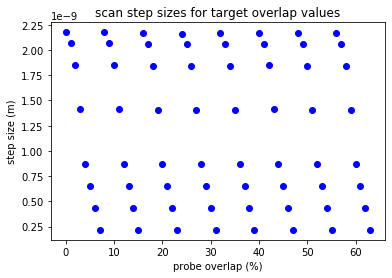

In [18]:
fig, ax = plt.subplots()

ax.plot(step_sizes, 'bo')

ax.set(title = 'scan step sizes for target overlap values',
       ylabel = 'step size (m)',
      xlabel = 'probe overlap (%)')

Text(0.5, 0, 'sim conditions')

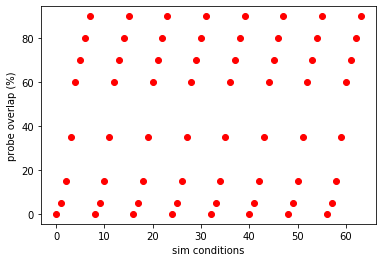

In [19]:
probe_overlaps_all = probe_overlaps * probes.shape[0]
plt.plot(probe_overlaps_all, 'ro')
plt.ylabel('probe overlap (%)')
plt.xlabel('sim conditions')

In [20]:
len(probe_overlaps_all)

64

Text(0.5, 0, 'sim conditions')

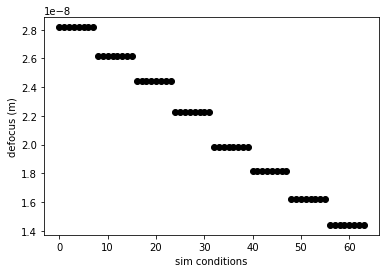

In [21]:
def_vals_all = [y for x in def_vals for y in (x,)*len(probe_overlaps)]
plt.plot(def_vals_all, 'ko')
plt.ylabel('defocus (m)')
plt.xlabel('sim conditions')

Text(0.5, 0, 'sim conditions')

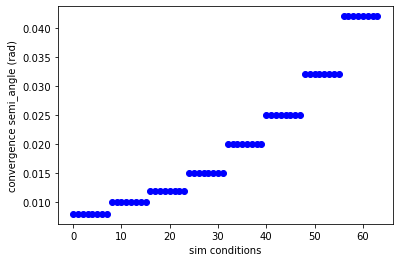

In [22]:
conv_semi_all = [y for x in conv_semi_list for y in (x,)*len(probe_overlaps)]
plt.plot(conv_semi_all, 'bo')
plt.ylabel('convergence semi_angle (rad)')
plt.xlabel('sim conditions')

In [23]:
conv_semi_all = np.asarray(conv_semi_all)
def_vals_all = np.asarray(def_vals_all)
step_sizes = np.asarray(step_sizes)
numbers_probe_pos = cell_dim * tiling_factor / step_sizes
sampling_factors = epsic.ptycho_utils.get_sampling_factor(pixel_size*detector_pix_array, probe_diameter, numbers_probe_pos, step_sizes)
sim_conditions = np.vstack((conv_semi_all, def_vals_all, step_sizes, sampling_factors))

In [24]:
print('sampling factor now ranges from ', min(sampling_factors), ' to ', max(sampling_factors))

sampling factor now ranges from  1.0001145584438142  to  8.212367113358845


In [25]:
sim_conditions[:,30]
# convergence semi-angle (rad), defocus (m), step_size (m)

array([1.50000000e-02, 2.22695568e-08, 4.32792538e-10, 4.19118537e+00])

In [26]:
sim_conditions.shape

(4, 64)

In [27]:
np.save('sim_condtions_64_def_512det', sim_conditions)

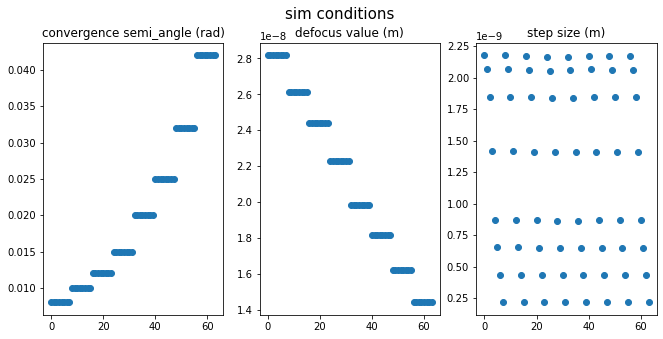

In [28]:
fig, axs = plt.subplots(1,3, figsize=(11, 5))
title = 'sim conditions'
fig.suptitle(title, fontsize = 15)

for i, ax in enumerate(axs.ravel()):
    ax.plot(sim_conditions[i,:], 'o')
    if i==0:
        ax.set_title('convergence semi_angle (rad)')
    if i==1:
        ax.set_title('defocus value (m)')
    if i==2:
        ax.set_title('step size (m)')


<a id='submit'></a>
# Submitting the sim matrix to cluster

In [29]:
pixel_size

8.5048828125e-12

In [37]:
xyz = '/dls/science/groups/e02/Mohsen/code/Git_Repos/Staff-notebooks/ptyREX_sim_matrix/xyz_files/Graphene_defect.xyz'
sim_npy = '/dls/science/groups/e02/Mohsen/code/Git_Repos/Staff-notebooks/ptyREX_sim_matrix/sim_condtions_64_def_512det.npy'
root_path = '/dls/e02/data/2020/cm26481-1/processing/pty_simulated_data_MD/sim_matrix_ptyREX_4June2020_512pixArray/'
script_path = '/dls/science/groups/e02/Mohsen/code/Git_Repos/Staff-notebooks/ptyREX_sim_matrix/'
dose = 2.5e8
shell_file = '/dls/science/groups/e02/Mohsen/code/Git_Repos/Staff-notebooks/ptyREX_sim_matrix/pyprismatic_matrix.sh'


In [38]:
import sys
import os
sys.path.append(script_path)

In [39]:
command_str = '\n cd '+ script_path + '\n module load global/cluster \n qsub pyprismatic_matrix.sh ' + xyz + ' ' + str(pixel_size)+ ' '+ sim_npy + ' ' + root_path + ' ' + script_path + ' ' + str(dose)
os.system(command_str)

0